# Importing necessary Libraries


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

# Resizing Images

In [14]:
# import tensorflow as tf
# import os

# def resize_images(input_base_folder, output_base_folder, width, height):
#     # Create the output base folder if it doesn't exist
#     if not os.path.exists(output_base_folder):
#         os.makedirs(output_base_folder)

#     # Iterate through each subfolder in the input base folder
#     for subfolder in os.listdir(input_base_folder):
#         input_folder = os.path.join(input_base_folder, subfolder)
#         output_folder = os.path.join(output_base_folder, subfolder)
        
#         # Create the corresponding subfolder in the output base folder if it doesn't exist
#         if not os.path.exists(output_folder):
#             os.makedirs(output_folder)

#         # Iterate through each image in the subfolder
#         for filename in os.listdir(input_folder):
#             if filename.endswith(".jpg") or filename.endswith(".png"):
#                 # Load and resize the image
#                 img = tf.keras.preprocessing.image.load_img(os.path.join(input_folder, filename))
#                 img = img.resize((width, height))
#                 img_array = tf.keras.preprocessing.image.img_to_array(img)
#                 img_array = tf.image.resize(img_array, [height, width])  # Note the order: height, width

#                 # Save the resized image in the corresponding output subfolder
#                 tf.keras.preprocessing.image.save_img(os.path.join(output_folder, filename), img_array)

# # Define the input and output base folders
# input_base_folder = 'dataset'  # Replace with the path to your dataset folder
# output_base_folder = 'resized_dataset'  # Replace with the path to your output folder

# # Define the target width and height
# width = 162
# height = 110

# # Resize the images
# resize_images('dataset', 'resized_dataset', width, height)

# Preparing Dataset

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'resized_dataset',
    seed = 123,
    shuffle = True,
    image_size=(162,110),
    batch_size=32
)

Found 967 files belonging to 10 classes.


In [5]:
len(dataset)

31

In [6]:
967/32


30.21875

In [5]:
class_names = dataset.class_names
print(class_names)

['Beagle', 'Boxer', 'Bulldog', 'Dachshund', 'German_Shepherd', 'Golden_Retriever', 'Labrador_Retriever', 'Poodle', 'Rottweiler', 'Yorkshire_Terrier']


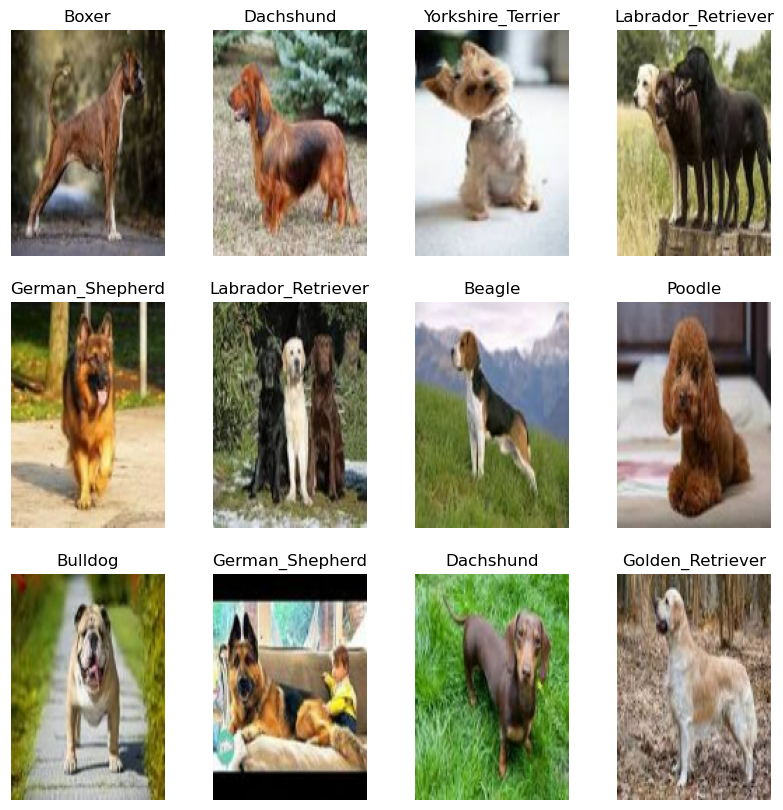

In [8]:
plt.figure(figsize=(10, 10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        image = image_batch[i].numpy().astype('uint8')
        label = class_names[label_batch[i]]
        plt.imshow(image)
        plt.title(label)
        plt.axis(False)

# Spliting dataset into Train,Validation and Test Data

In [9]:
def split_data(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = sum(1 for _ in dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = ds_size - (train_size + val_size)
    
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size)
    
    return train_ds, val_ds, test_ds



In [10]:

train_ds,val_ds,test_ds = split_data(dataset)

In [11]:
len(train_ds)

24

In [12]:
len(test_ds)

4

In [13]:
len(val_ds)

3

# Implementing Prefetch to improve Cache Performance

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Training

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(110, 162),
    layers.Rescaling(1./255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

In [17]:
input_shape = ( 162, 110, 3)
n_classes = len(class_names)

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

C:\Users\rushi\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [18]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 110, 162, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 108, 160, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 54, 80, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 52, 78, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 26, 39, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 10, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         163,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 257,802 (1007.04 KB)

 Trainable params: 257,802 (1007.04 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
    callbacks=[early_stopping]
)




Epoch 1/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.1408 - loss: 2.3075 - val_accuracy: 0.1667 - val_loss: 2.2591
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.2407 - loss: 2.1586 - val_accuracy: 0.3229 - val_loss: 1.8450
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.4107 - loss: 1.6322 - val_accuracy: 0.6667 - val_loss: 1.1498
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.7151 - loss: 0.8517 - val_accuracy: 0.8542 - val_loss: 0.5620
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9186 - loss: 0.2924 - val_accuracy: 0.9271 - val_loss: 0.2613
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9512 - loss: 0.1880 - val_accuracy: 0.9792 - val_loss: 0.0791
Epoch 7/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9913 - loss: 0.0469 - val_accuracy: 1.0000 - val_loss: 0.0277
Epoch 8/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9899 - loss: 0.0395 - val_accuracy: 0.

In [21]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [23]:
acc = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

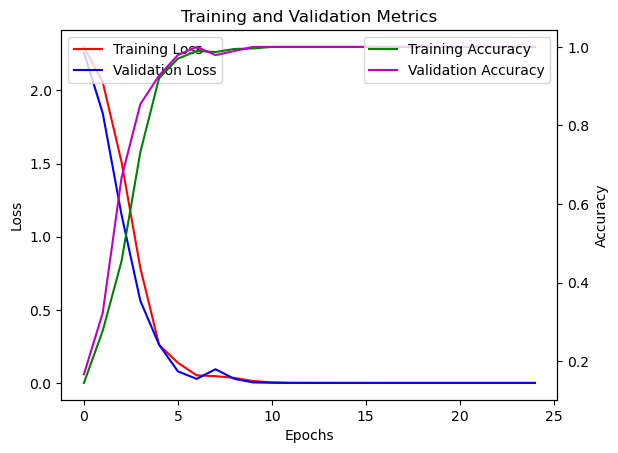

In [24]:
fig, ax1 = plt.subplots()

# Plotting loss vs epochs
ax1.plot(history.history['loss'], label='Training Loss', color='r')
ax1.plot(history.history['val_loss'], label='Validation Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')

# Creating a twin axes sharing the x-axis
ax2 = ax1.twinx()
# Plotting accuracy vs epochs
ax2.plot(history.history['accuracy'], label='Training Accuracy', color='g')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='m')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper right')

plt.title('Training and Validation Metrics')
plt.show()


# Prediction


In [25]:
def predict(model,image):
    img_arr = tf.keras.preprocessing.image.img_to_array(image)
    img_arr = tf.expand_dims(img_arr, 0)
    prediction = model.predict(img_arr)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = round(100 * (np.max(prediction)), 2)
    return predicted_class ,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


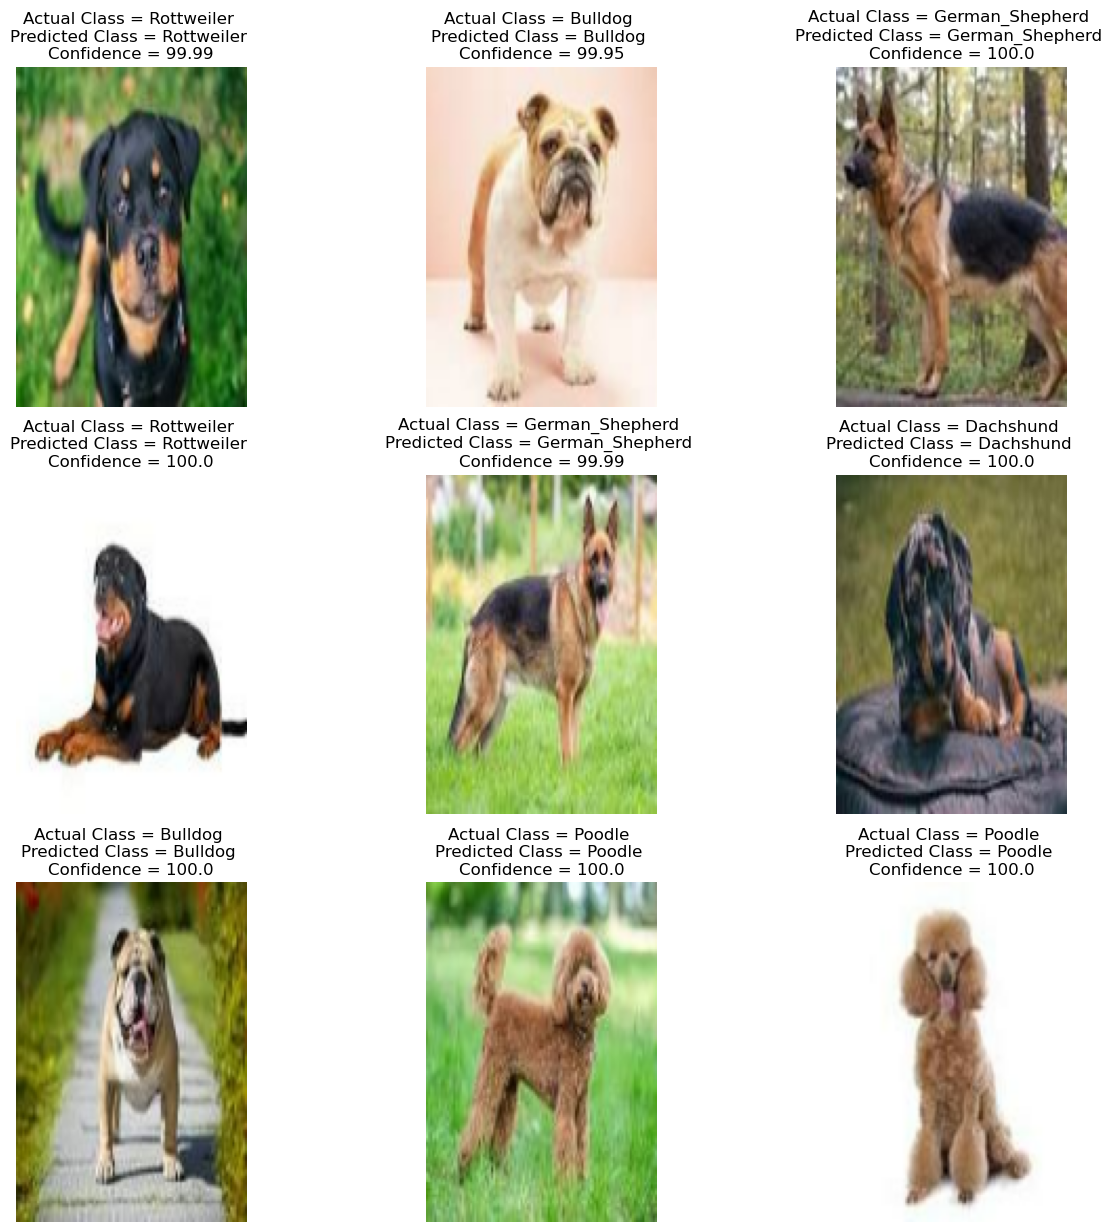

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

for image_batch, label_batch in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        predicted_class, confidence = predict(model, image_batch[i])
        plt.title(f'Actual Class = {class_names[label_batch[i]]} \nPredicted Class = {predicted_class} \nConfidence = {confidence}')

plt.show()

In [27]:
import os
save_dir = os.path.join( 'models')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
model_name = 'my_model.keras'
save_path = os.path.join(save_dir, model_name)
model.save(save_path)
print(f'Model saved to {save_path}')

Model saved to models\my_model.keras
